In [1]:
'''
Date: 2022.07.27
Title: 영화 평점 예측하기
By: Kang Jin Seong
'''

# -*- coding: utf-8 -*-

%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
''' Movielens 데이터셋의 기본정보'''

rating_file_path = 'C:/Users/USER/DataAnalysis_jupyter/ratings.dat'
movie_file_path = 'C:/Users/USER/DataAnalysis_jupyter/movies.dat'
user_file_path = 'C:/Users/USER/DataAnalysis_jupyter/users.dat'

rating_data = pd.io.parsers.read_csv(rating_file_path, names = ['user_id', 'movie_id', 'rating', 'time'], delimiter = '::',
                                    encoding = 'ISO-8859-1')
movie_data = pd.io.parsers.read_csv(movie_file_path, names =['movie_id', 'title', 'genre'], delimiter = '::',
                                   encoding = 'ISO-8859-1')
user_data = pd.io.parsers.read_csv(user_file_path, names =['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter = '::',
                                  encoding = 'ISO-8859-1')

In [3]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
'''
탐색적 데이터 분석
'''

# 분석할 영화의 정보 탐색하기
print('total number of movie in data:', len(movie_data['movie_id'].unique()))

#연도별 영화 개수가 많은 TOP 10년도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data: 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

In [7]:
'''
장르의 속성 탐색
'''

#가장 많이 사용된 장르의 조합을 출력합니다.(top 10)
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

In [8]:
#가장 많이 등장한 장르의 속성을 추출합니다.(top 10)
unique_genre_dict = {}

for index, row in movie_data.iterrows():
    #genre 피처를 '|' 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split('|')
    
    #구분자로 분리한 장르의 속성을 unique_genre_dict 에 각각 계산하여 저장한다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


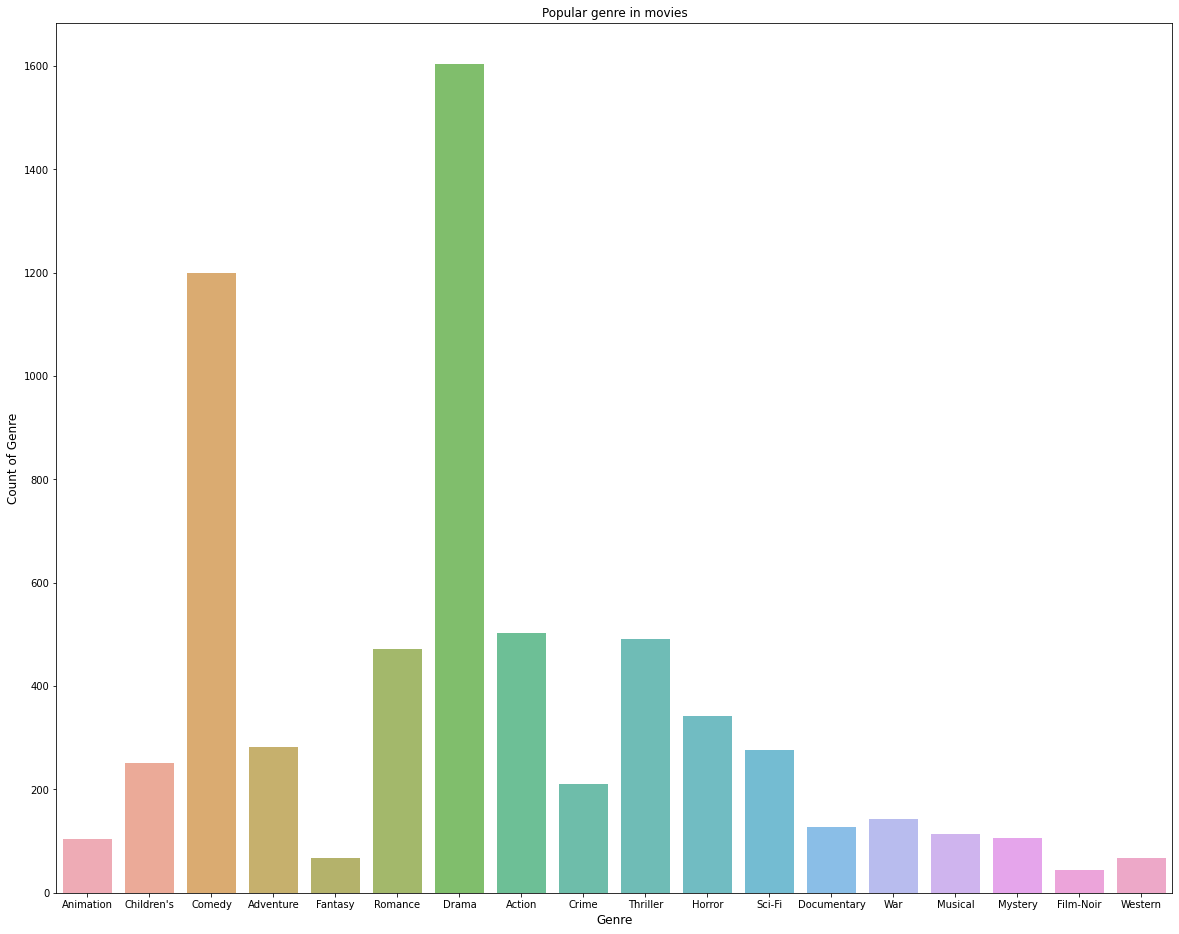

In [9]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha = 0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize = 12)
plt.xlabel('Genre', fontsize = 12)
plt.show()

In [10]:
# 분석할 유저의 정보 탐색하기
print('total number of user in data:', len(user_data['user_id'].unique()))

total number of user in data: 6040


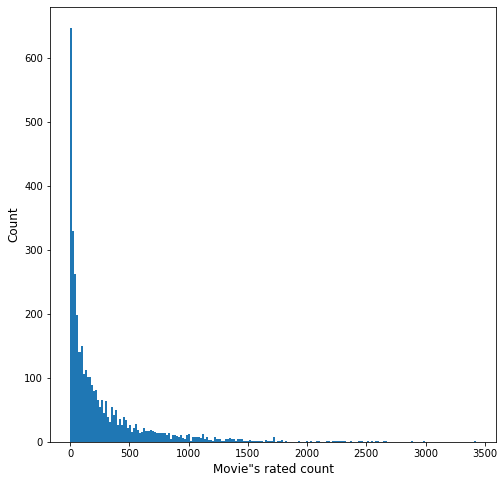

In [11]:
'''
평점 데이터의 정보 탐색하기
'''

# 각 영화들이 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8,8]
fig = plt.hist(movie_rate_count, bins = 200)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Movie"s rated count', fontsize = 12)
plt.show()

In [12]:
print("total number of movie in data:", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100:", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data: 3883
total number of movie rated below 100: 1687


In [13]:
# 영화별 평균 평점을 탐색한다.
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count', 'mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot:>

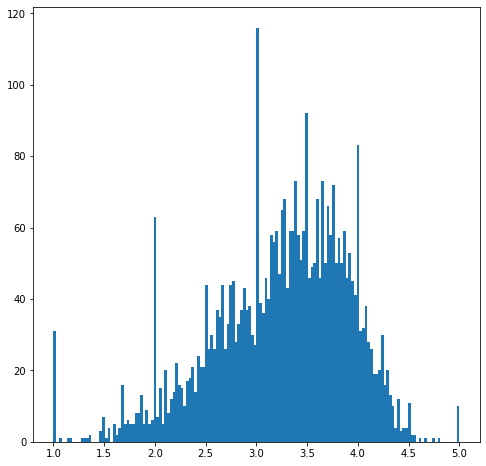

In [14]:
movie_grouped_rating_info['rating_mean'].hist(bins = 150, grid = False)

In [15]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력합니다.
merged_data = movie_grouped_rating_info.merge(movie_data, on = ['movie_id'], how = 'left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


In [16]:
'''
user-movie 형태의 테이블로 살펴보기
 - UIR: user item rating
'''

rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [17]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(['user_id', 'movie_id']).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

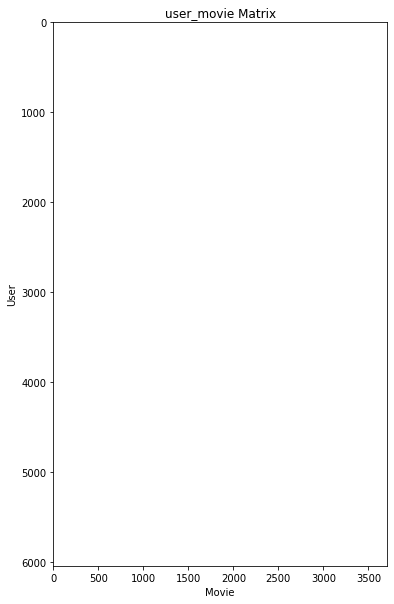

In [18]:
# user_movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel('Movie');plt.ylabel('User')
plt.title("user_movie Matrix")
plt.show()

In [19]:
'''
수학적 기법을 활용한 평점 예측
'''
# SVD를 활용한 빈칸 채우기

from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress = True)

reader = Reader(rating_scale = (1,5))

In [20]:
# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
               'user_id': ['a', 'a','a','b','b','b','c'],
               'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [21]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(['user_id', 'item_id']).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

In [22]:
# SVD를 이용한 빈칸 채우기 학습
data = Dataset.load_from_df(df = df[['user_id', 'item_id', 'rating']], reader = reader)
train_data = data.build_full_trainset()

In [23]:
# SVD 모델을 학습합니다.
model = SVD(n_factors = 8,
           lr_all = 0.005,
           reg_all = 0.02,
           n_epochs = 10)
model.fit(train_data)

In [24]:
# 학습한 모델을 기반으로 빈 공간의 점수를 예측합니다.

'''
build_anti_testset() :
학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터,
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출
'''

# test_data: 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터 입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)


#  아래의 결과는 빈공간(test_data)의 점수를 에측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print('item_id', iid, "|", 'predicted rating:', predicted_rating)

item_id 1 | predicted rating: 3.665040930411517
item_id 3 | predicted rating: 3.798656716070967


In [25]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 1 | real rating : 2.0 | predicted rating : 3.450694757018348
Item id 2 | real rating : 4.0 | predicted rating : 3.811178357787082
Item id 3 | real rating : 4.0 | predicted rating : 3.6513321235924963
Item id 1 | real rating : 2.0 | predicted rating : 3.524072340284565
Item id 2 | real rating : 5.0 | predicted rating : 3.922118818258392
Item id 3 | real rating : 4.0 | predicted rating : 3.7822410312548183
Item id 2 | real rating : 5.0 | predicted rating : 3.925320812535584


In [26]:
'''
아직 평가하지 않은 영화의 점수 예측하기
'''

# movielens 데이터에 SVD 적용하기
reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors = 8,
           lr_all =0.005,
           reg_all = 0.02,
           n_epochs = 100)
model.fit(train_data)
train_end =  time.time()
print('training time of model: %.2f seconds' %(train_end - train_start))

training time of model: 101.14 seconds


In [27]:
# 영화의 점수를 예측할 타겟 유저 선정

# user_id가 4인 유저의 영화 평가 데이터 입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id'] == target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [28]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
    
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


In [29]:
# 타겟 유저가 보지않은 영화 중, 예상 평점이 높은 10개 선정
# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.

test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating  = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [30]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_perdict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions = target_user_predictions,
                                                           user_id = target_user_id,
                                                           user_history = target_user_movie_rating_dict)

In [31]:
# target_uset_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 TOP 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(),
                                    key = operator.itemgetter(1), reverse = True)[:10]

In [32]:
# 예측된 TOP 10 영화
target_user_top10_predicted

[(199, 5),
 (326, 5),
 (527, 5),
 (602, 5),
 (608, 5),
 (615, 5),
 (669, 5),
 (670, 5),
 (750, 5),
 (858, 5)]

In [33]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [34]:
# 앞서 계산한 Top10 영화에 movie_title을 매핑하여 출력합니다.

for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Aparajito (1956) : 5
World of Apu, The (Apur Sansar) (1959) : 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : 5
Godfather, The (1972) : 5


In [35]:
# 타겟 유저의 기존 선호 영화와 비교합니다.

target_user_top10_real = sorted(target_user_movie_rating_dict.items(),
                               key = operator.itemgetter(1), reverse = True)[:10]

for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":",real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


In [39]:
'''
예측 모델 평가하기
 - 행렬완성의 가장 보편적인 평가 방법은 RMSE를 계산하는것
'''

# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할 합니다.
reader = Reader(rating_scale = (1,5))
data  = Dataset.load_from_df(rating_data[['user_id', 'movie_id','rating']],reader)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors = 8,
           lr_all = 0.005,
           reg_all = 0.02,
           n_epochs = 100)
model.fit(train_data)
train_end = time.time()
print('Training time of model: %.2f seconds' %(train_end - train_start))

# 테스트 데이터의 RMSE를 출력합니다.
print('RMSE of test dataset in SVD model:')
accuracy.rmse(predictions)

Training time of model: 108.97 seconds
RMSE of test dataset in SVD model:
RMSE: 0.9963


0.9963301836137258

In [42]:
'''
실제 평점과의 비교 시각화
 - 4번 유저의 예측 평점과 실제 평점을 비교하는 시각화 그래프를 출력
 - 4번 유저가 영화를 아직 보지 않았다는 가정하에 실제로 보았던 21개 영화의 가상 에측 평점을 계산
'''

# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = [ ]
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))
        
# print(test_data)

[(4, 260, 5), (4, 480, 4), (4, 1036, 4), (4, 1097, 4), (4, 1196, 2), (4, 1198, 5), (4, 1201, 5), (4, 1210, 3), (4, 1214, 4), (4, 1240, 5), (4, 1387, 5), (4, 1954, 5), (4, 2028, 5), (4, 2366, 4), (4, 2692, 5), (4, 2947, 5), (4, 2951, 4), (4, 3418, 4), (4, 3468, 5), (4, 3527, 1), (4, 3702, 4)]


In [44]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 TOP 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions = target_user_predictions,
                                                           user_id = target_user_id,
                                                            user_history = target_user_movie_rating_dict)

In [45]:
target_user_movie_predict_dict

{260: 4.276719691010293,
 480: 3.364886639072083,
 1036: 4.106649377376187,
 1097: 4.401623459987075,
 1196: 3.968356972849249,
 1198: 4.509697420720704,
 1201: 4.496846881883595,
 1210: 3.4816957226039094,
 1214: 4.420150783653897,
 1240: 4.218617280929983,
 1387: 4.370812122122573,
 1954: 4.235220182955524,
 2028: 4.42500333263967,
 2366: 4.138162040771133,
 2692: 4.23849426379004,
 2947: 4.397002812402782,
 2951: 4.368783540622778,
 3418: 4.307918698259733,
 3468: 4.848023851480235,
 3527: 3.370518778542884,
 3702: 4.056239831230995}

In [46]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0

for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print('movie', str(idx), ':', movie_title, '-', origin_rating, '/', predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))


movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.28
movie 2 : Jurassic Park (1993) - 4 / 3.36
movie 3 : Die Hard (1988) - 4 / 4.11
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.4
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.97
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.51
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.5
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.48
movie 9 : Alien (1979) - 4 / 4.42
movie 10 : Terminator, The (1984) - 5 / 4.22
movie 11 : Jaws (1975) - 5 / 4.37
movie 12 : Rocky (1976) - 5 / 4.24
movie 13 : Saving Private Ryan (1998) - 5 / 4.43
movie 14 : King Kong (1933) - 4 / 4.14
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.24
movie 16 : Goldfinger (1964) - 5 / 4.4
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.37
movie 18 : Thelma & Louise (1991) - 4 / 4.31
movie 19 : Hustler, The (1961) - 5 / 4.85
movie 20 : Predator (1987) - 1 / 3.37
movie 21 : Mad Max (1979) - 4 / 4.06


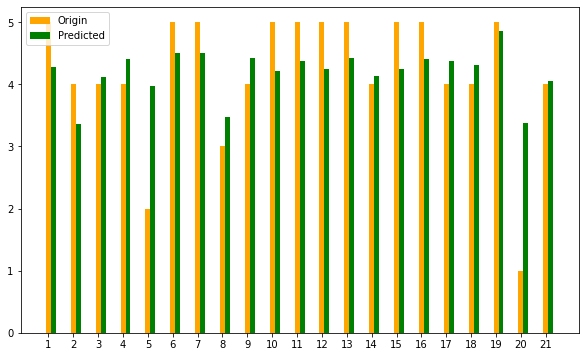

In [48]:
'''
결과의 시각화
'''

# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list

# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10, 6)
index = np.arange(len(movie_title_list))
bar_width = 0.2

# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                color = 'orange',
                label = 'Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                color = 'green',
                label = 'Predicted')

plt.xticks(index, movie_title_list)
plt.legend()
plt.show()